<a href="https://colab.research.google.com/github/shaySitri/LyricsGenerator/blob/main/Lyrics_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - Assignment 3


In [ ]:
import pretty_midi
import matplotlib.pyplot as plt
import pandas as pd
import os
from gensim.models import Word2Vec
from collections import Counter
import seaborn as sns
import nltk
import re
import numpy as np
from sklearn.decomposition import PCA
import gensim
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch
from torch import optim
import unicodedata
import math
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import string
from sklearn.model_selection import train_test_split
import neptune
import time
from neptune.types import File
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import gensim.downloader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Preprocess

In [ ]:
midi_dir = ""

In [ ]:
train_df = pd.read_csv(f"{midi_dir}/lyrics_train_set.csv", header=None)

In [ ]:
# check whayt are the "messy rows" (those with more than 1 song)
train_df.isnull().sum()

0      0
1      0
2      0
3    586
4    586
5    599
6    599
dtype: int64

In [ ]:
map_song_path = {'singer':[], 'song':[], 'path':[]}
# assign directory
directory = f'{midi_dir}/midi_files'

# map all the midi file to their corresponsings lyrics
for file in os.listdir(directory):
    file_name = file.split("-")
    singer = file_name[0].replace("_", " ")[:-1].lower()
    song = file_name[1].split(".")
    song = song[0].replace("_", " ")[1:].lower()
    map_song_path['singer'].append(singer)
    map_song_path['song'].append(song)
    map_song_path['path'].append(file)

map_song_path = pd.DataFrame(map_song_path)

In [ ]:
map_song_path

,singer,song,path
0,the fugees,ready or not,The_Fugees_-_Ready_or_Not.mid
1,the fugees,no woman no cry,The_Fugees_-_No_Woman_No_Cry.mid
2,the fugees,killing me softly,The_Fugees_-_Killing_Me_Softly.mid
3,the four seasons,walk like a man,The_Four_Seasons_-_Walk_Like_a_Man.mid
4,the four seasons,sherry,The_Four_Seasons_-_Sherry.mid
...,...,...,...
620,2 unlimited,twilight zone,2_Unlimited_-_Twilight_Zone.mid
621,2 unlimited,tribal dance,2_Unlimited_-_Tribal_Dance.mid
622,2 unlimited,let the beat control your body,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid
623,2 unlimited,get ready for this,2_Unlimited_-_Get_Ready_for_This.mid


In [ ]:
# leave only the rows with more than 3 columns
train_df_double_rows = train_df.dropna(thresh=4)

In [ ]:
# parse the path into singer & song
def append_song_to_dict(rows_dict, row):
    singer = row[0]
    song1 = row[1]
    lyrics1 = row[2]
    song2 = row[3]
    lyrics2 = row[4]
    rows_dict['singer'].append(singer)
    rows_dict['song'].append(song1)
    rows_dict['lyrics'].append(lyrics1)
    rows_dict['singer'].append(singer)
    rows_dict['song'].append(song2)
    rows_dict['lyrics'].append(lyrics2)
    if not pd.isna(row[5]):
        song3 = row[5]
        lyrics3 = row[6]
        rows_dict['singer'].append(singer)
        rows_dict['song'].append(song3)
        rows_dict['lyrics'].append(lyrics3)

In [ ]:
# repair the wrong rows (those with more than 3 columns)
repaired_rows = {'singer':[], 'song':[], 'lyrics':[]}
train_df_double_rows.apply(lambda x: append_song_to_dict(repaired_rows, x) , axis = 1, raw = True)
repaired_rows = pd.DataFrame(repaired_rows)

In [ ]:
# remove the repaird rows from the original data set
train_df = train_df.drop(list(train_df_double_rows.index), axis=0)

In [ ]:
# leave only the relevant columns
train_df = train_df[[0,1,2]]
train_df.columns = ['singer', 'song', 'lyrics']

In [ ]:
# concat the repaired rows and the original data set
train_df = pd.concat([train_df, repaired_rows])

In [ ]:
train_df = train_df.merge(map_song_path, how='left', on=['singer', 'song'])

In [ ]:
# songs without midi file
train_df.isnull().sum()

singer    0
song      0
lyrics    0
path      5
dtype: int64

In [ ]:
# remove songs without midi & duplicates songs if exist
train_df = train_df.dropna()

In [ ]:
train_df = train_df.reset_index()[['singer','song','lyrics','path']]

In [ ]:
train_df

,singer,song,lyrics,path
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...,Elton_John_-_Candle_in_the_Wind.mid
1,gerry rafferty,baker street,winding your way down on baker street & lite i...,Gerry_Rafferty_-_Baker_Street.mid
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...,Gerry_Rafferty_-_Right_Down_the_Line.mid
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,2_Unlimited_-_Tribal_Dance.mid
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid
...,...,...,...,...
605,ace of base,don't turn around,if you want to leave & i won't beg you to st...,Ace_of_Base_-_Don't_Turn_Around.mid
606,backstreet boys,i'll never break your heart,baby i know you're hurting & right now you f...,Backstreet_Boys_-_I'll_Never_Break_Your_Heart.mid
607,backstreet boys,larger than life,i may run and hide & when you're screamin' my ...,Backstreet_Boys_-_Larger_Than_Life.mid
608,bee gees,jive talkin',it's just your jive talkin' & you're telling...,Bee_Gees_-_Jive_Talkin'.mid


In [ ]:
test_df = pd.read_csv(f"{midi_dir}/lyrics_test_set.csv", header=None)

In [ ]:
# leave only the relevant columns
test_df = test_df[[0,1,2]]
test_df.columns = ['singer', 'song', 'lyrics']

In [ ]:
test_df['song'] = test_df.apply(lambda x: x[1][1:], axis = 1, raw=True)

In [ ]:
test_df = pd.merge(test_df, map_song_path, how='left', on=['singer', 'song'])


## Tokenization Step

In [ ]:
def fix_lyrics(lyrics):
    """
      Function to clean up song lyrics by removing repetitive markers like  'repeat', and similar patterns.

      Parameters:
      lyrics (str): The original song lyrics.

      Returns:
      str: The song lyrics after removing the repetitive markers.
    """
    pattern = r"\b(?:\d*x\d+|\d+x|x\d+|repeatx+\d+|x+\d+repeat|repeat|X|x|chorus)\b"
    matches = re.search(pattern, lyrics)
    if matches != None:
        lyrics = re.sub(pattern, "", lyrics)
    return lyrics

In [ ]:
def remove_non_ascii_words(text):
    """
      Function to remove words from a text that contain non-ASCII characters and filter out non-printable ASCII characters.

      Parameters:
      text (str): The original text.

      Returns:
      str: The text after removing non-ASCII words and filtering out non-printable ASCII characters.
      """
    split = text.split()
    flag = False
    for token in split:
        if not token.isascii():
            text = text.replace(token, '')
            flag = True

    printable = set(string.printable)

    # Filter out non-printable ASCII characters
    filtered_text = ''.join(filter(lambda x: x in printable, text))

    return filtered_text


In [ ]:
all_tokens = []
def tokenizer(lyrics, token_list):
    """
        Function to tokenize song lyrics, replacing certain characters with spaces, and handling special cases.

        Parameters:
        lyrics (str): The original song lyrics.
        token_list (list): The list to which the tokens will be added.

        Returns:
        str: The processed and tokenized lyrics.
    """
    replace_tokens_none = ['!',',','.','?',"'",'&',';','*','#',':','`', '(',')','"','$','%','@','#','+']
    replace_tokens_space = ['-','\t']
    list_of_tokens = lyrics.split(" ")
    for i in range(len(list_of_tokens)):
        token = list_of_tokens[i]

        if token != '&' and not token.isalpha():
            for nones_tokens in replace_tokens_none:
                token = token.replace(nones_tokens,'')
            for space_tokens in replace_tokens_space:
                token = token.replace(space_tokens,' ')
            if '[' in token or ']' in token or '{' in token or '}' in token:
                token = ''
        # token = ps.stem(token)
        list_of_tokens[i] = token
    list_of_tokens[-1] = 'eos'
    list_of_tokens = [token for token in list_of_tokens if token != '']

    pos = 0
    for token in list_of_tokens:
        if not token.isalpha():
            pos += 1
        else:
            break

    list_of_tokens = list_of_tokens[pos:]
    repaired_lyrics = ' '.join(list_of_tokens).replace("& &", "&")
    # repaired_lyrics = repaired_lyrics.replace("&", "<EOL>")
    repaired_lyrics = repaired_lyrics.replace("&", "eol")
    list_of_tokens = repaired_lyrics.split()
    token_list.extend(list_of_tokens)
    return repaired_lyrics

In [ ]:
all_tokens = []
train_df['lyrics'] = train_df.apply(lambda x: fix_lyrics(x[2]) , axis = 1, raw = True)
train_df['lyrics'] = train_df.apply(lambda x: remove_non_ascii_words(x[2]) , axis = 1, raw = True)
train_df['lyrics'] = train_df.apply(lambda x: tokenizer(x[2], all_tokens) , axis = 1, raw = True, result_type='expand')

all_tokens = Counter(all_tokens)

In [ ]:
train_df

,singer,song,lyrics,path
0,elton john,candle in the wind,goodbye norma jean eol though i never knew you...,Elton_John_-_Candle_in_the_Wind.mid
1,gerry rafferty,baker street,winding your way down on baker street eol lite...,Gerry_Rafferty_-_Baker_Street.mid
2,gerry rafferty,right down the line,you know i need your love eol youve got that h...,Gerry_Rafferty_-_Right_Down_the_Line.mid
3,2 unlimited,tribal dance,come on check it out yall eol come on come on ...,2_Unlimited_-_Tribal_Dance.mid
4,2 unlimited,let the beat control your body,let the beat control your body eol let the bea...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid
...,...,...,...,...
605,ace of base,don't turn around,if you want to leave eol i wont beg you to sta...,Ace_of_Base_-_Don't_Turn_Around.mid
606,backstreet boys,i'll never break your heart,baby i know youre hurting eol right now you fe...,Backstreet_Boys_-_I'll_Never_Break_Your_Heart.mid
607,backstreet boys,larger than life,i may run and hide eol when youre screamin my ...,Backstreet_Boys_-_Larger_Than_Life.mid
608,bee gees,jive talkin',its just your jive talkin eol youre telling me...,Bee_Gees_-_Jive_Talkin'.mid


In [ ]:
test_tokens = []
test_df['lyrics'] = test_df.apply(lambda x: fix_lyrics(x[2]) , axis = 1, raw = True)
test_df['lyrics'] = test_df.apply(lambda x: remove_non_ascii_words(x[2]) , axis = 1, raw = True)
test_df['lyrics'] = test_df.apply(lambda x: tokenizer(x[2], test_tokens) , axis = 1, raw = True, result_type='expand')


In [ ]:
test_tokens = Counter(test_tokens)

## Create statistics

In [ ]:
def lyrics_statistics(lyrics):
    """
      Function to compute statistics about song lyrics, such as total word count, number of lines, average words per line, and the maximum line length.

      Parameters:
      lyrics (str): The song lyrics to analyze.

      Returns:
      tuple: A tuple containing the following statistics:
          - song_len_per_words (int): The total number of words in the song.
          - total_lines (int): The total number of lines in the song.
          - average_words_per_line (float): The average number of words per line.
          - max_line_len (int): The maximum number of words in a single line.
    """
    line_len_per_words = []
    split_lyrics = lyrics.split(' ')
    line_len = 0
    for token in split_lyrics:
        if token != 'eol' and token != 'eos':
            line_len += 1
        else:
            line_len_per_words.append(line_len)
            line_len = 0
    song_len_per_words = sum(line_len_per_words)
    total_lines = len(line_len_per_words)
    average_words_per_line = song_len_per_words / total_lines
    max_line_len = max(line_len_per_words)
    return song_len_per_words, total_lines, average_words_per_line, max_line_len


In [ ]:
train_df[['total words','total lines','avg line','max line']] = train_df.apply(lambda x: lyrics_statistics(x[2]) , axis = 1, raw = True, result_type='expand')


In [ ]:
train_df

,singer,song,lyrics,path,total words,total lines,avg line,max line
0,elton john,candle in the wind,goodbye norma jean eol though i never knew you...,Elton_John_-_Candle_in_the_Wind.mid,300.0,50.0,6.000000,9.0
1,gerry rafferty,baker street,winding your way down on baker street eol lite...,Gerry_Rafferty_-_Baker_Street.mid,227.0,29.0,7.827586,13.0
2,gerry rafferty,right down the line,you know i need your love eol youve got that h...,Gerry_Rafferty_-_Right_Down_the_Line.mid,218.0,33.0,6.606061,13.0
3,2 unlimited,tribal dance,come on check it out yall eol come on come on ...,2_Unlimited_-_Tribal_Dance.mid,263.0,39.0,6.743590,11.0
4,2 unlimited,let the beat control your body,let the beat control your body eol let the bea...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid,350.0,54.0,6.481481,10.0
...,...,...,...,...,...,...,...,...
605,ace of base,don't turn around,if you want to leave eol i wont beg you to sta...,Ace_of_Base_-_Don't_Turn_Around.mid,275.0,57.0,4.824561,8.0
606,backstreet boys,i'll never break your heart,baby i know youre hurting eol right now you fe...,Backstreet_Boys_-_I'll_Never_Break_Your_Heart.mid,272.0,44.0,6.181818,15.0
607,backstreet boys,larger than life,i may run and hide eol when youre screamin my ...,Backstreet_Boys_-_Larger_Than_Life.mid,222.0,35.0,6.342857,10.0
608,bee gees,jive talkin',its just your jive talkin eol youre telling me...,Bee_Gees_-_Jive_Talkin'.mid,239.0,63.0,3.793651,7.0


In [ ]:
train_df[['total words','total lines','avg line','max line']].sum()/len(train_df)

total words    259.688525
total lines     39.457377
avg line         7.796745
max line        12.270492
dtype: float64

In [ ]:
test_df[['total words','total lines','avg line','max line']] = train_df[['total words','total lines','avg line','max line']].sum()/len(train_df)

/tmp/ipykernel_1290211/2315440790.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_df[['total words','total lines','avg line','max line']] = train_df[['total words','total lines','avg line','max line']].sum()/len(train_df)
/tmp/ipykernel_1290211/2315440790.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_df[['total words','total lines','avg line','max line']] = train_df[['total words','total lines','avg line','max line']].sum()/len(train_df)
/tmp/ipykernel_1290211/2315440790.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

In [ ]:
test_df

,singer,song,lyrics,path,total words,total lines,avg line,max line
0,the bangles,eternal flame,close your eyes give me your hand darling eol ...,The_Bangles_-_Eternal_Flame.mid,259.688525,39.457377,7.796745,12.270492
1,billy joel,honesty,if you search for tenderness eol it isnt hard ...,Billy_Joel_-_Honesty.mid,259.688525,39.457377,7.796745,12.270492
2,cardigans,lovefool,dear i fear were facing a problem eol you love...,Cardigans_-_Lovefool.mid,259.688525,39.457377,7.796745,12.270492
3,aqua,barbie girl,hiya barbie eol hi ken eol do you want to go f...,Aqua_-_Barbie_Girl.mid,259.688525,39.457377,7.796745,12.270492
4,blink 182,all the small things,all the small things eol true care truth bring...,Blink_182_-_All_the_Small_Things.mid,259.688525,39.457377,7.796745,12.270492


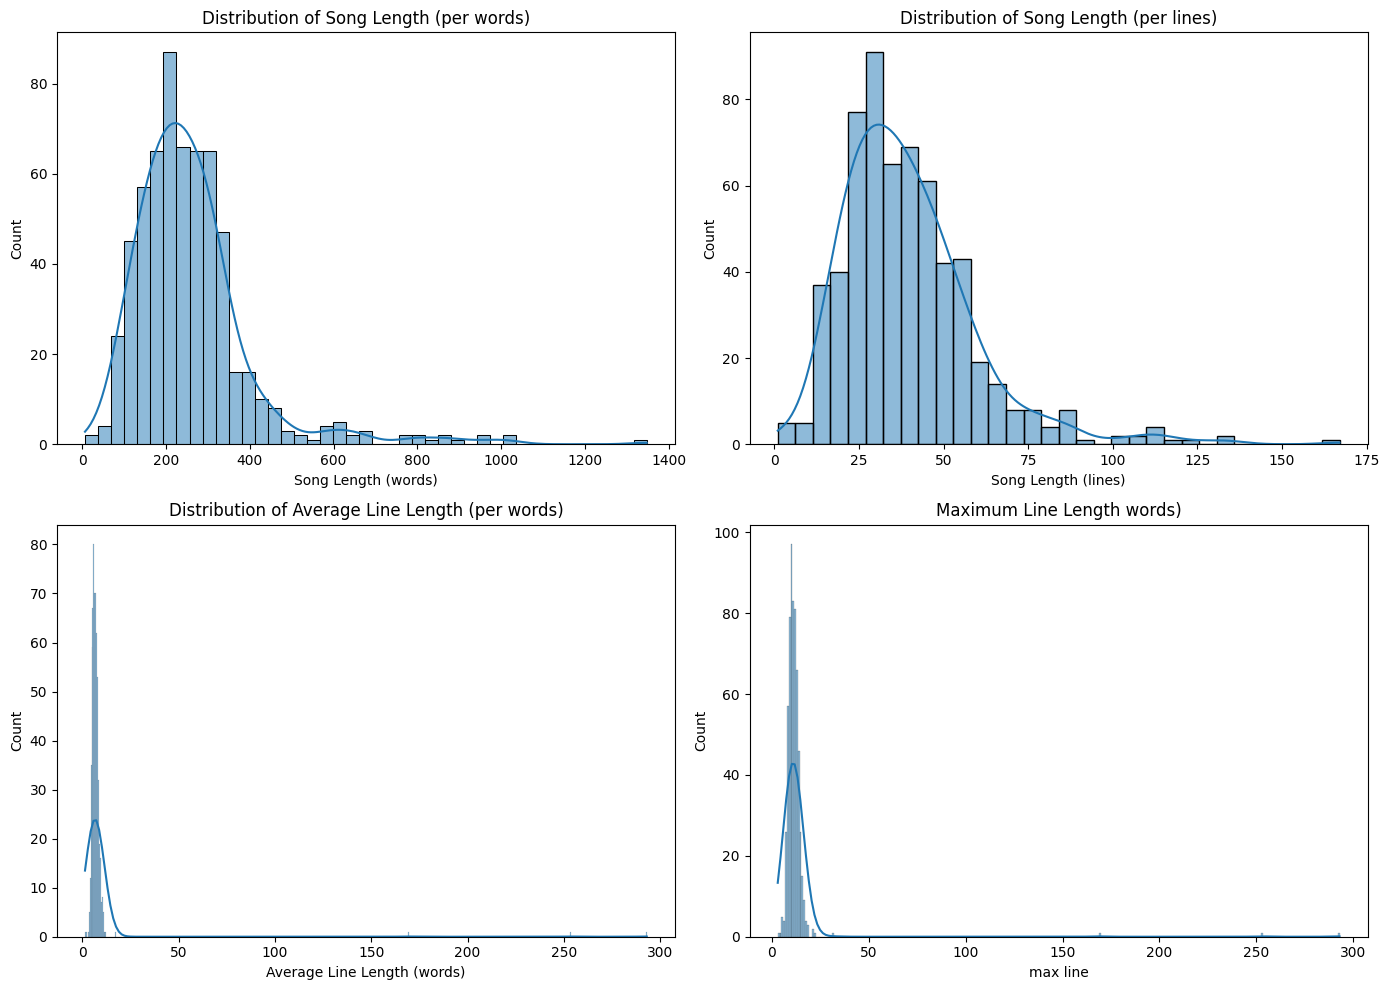

In [ ]:
x_axes = range(len(train_df))
fig, axs = plt.subplots(2, 2, figsize=(14, 10))


# # Plotting on each subplot
sns.histplot(data=train_df, x="total words", kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Distribution of Song Length (per words)")
axs[0, 0].set_xlabel("Song Length (words)")

sns.histplot(data=train_df, x="total lines", kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Distribution of Song Length (per lines)")
axs[0, 1].set_xlabel("Song Length (lines)")

sns.histplot(data=train_df, x="avg line", kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Distribution of Average Line Length (per words)")
axs[1, 0].set_xlabel("Average Line Length (words)")

sns.histplot(data=train_df, x="max line", kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Distribution of Maximum Line Length (per words)")
axs[1, 1].set_title("Maximum Line Length words)")

plt.tight_layout()
plt.show()

Singer statistics (we will use it for validation purpose)

In [ ]:
grouped_singer = train_df.groupby('singer').count()

In [ ]:
grouped_singer = grouped_singer.sort_values(by=['song'], ascending=False)

In [ ]:
top_15_singers = grouped_singer.head(15)
top_15_singers["song"]

singer
the eagles          24
the corrs           24
christmas carols    23
billy joel          19
genesis             18
bee gees            15
backstreet boys     15
the carpenters      13
abba                11
eminem              10
boyzone              9
britney spears       9
billy idol           8
bread                8
cyndi lauper         7
Name: song, dtype: int64

We will split our training data into: short songs, average song, long song (determine by the word number in the song)

In [ ]:
train_df['total words'].describe()

count     610.000000
mean      259.688525
std       146.023025
min         7.000000
25%       171.000000
50%       236.000000
75%       304.000000
max      1347.000000
Name: total words, dtype: float64

In [ ]:
# Define bins and labels
bins = [0, 172,  305, 1348]
labels = ['short', 'mid', 'long']

# Cut the 'total words' column into bins and assign labels
train_df['song cat'] = pd.cut(train_df['total words'], bins=bins, labels=labels, right=False)
test_df['song cat'] = '-'


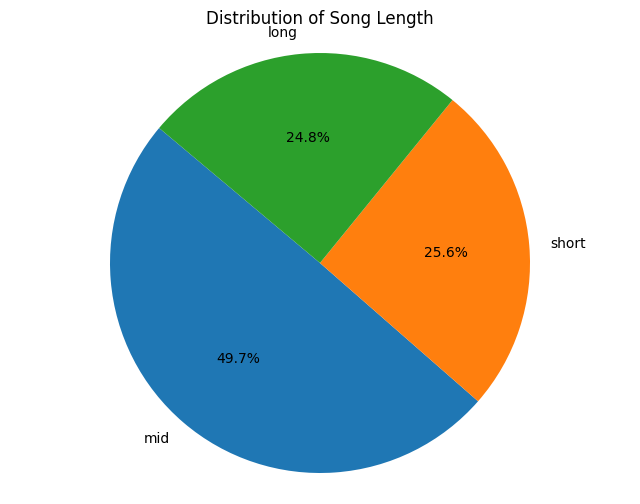

In [ ]:
# Calculate counts for each category
counts = train_df['song cat'].value_counts()

# Plotting a pie chart using matplotlib
plt.figure(figsize=(8, 6))
plt.title('Distribution of Song Length')
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

When we will split to train $ validation we would like to keep this balnced.

## Word2Vec

Now, we want to train word2vec model, For this purpose we took dataset of lyrics sothat our word2vec fit to our task.
We going to use the same preprocess as we used on the train dataset.

[Data Set](https://www.kaggle.com/datasets/paulinechaumeron/lyrics2music?select=mood_data_balanced.csv)

In [ ]:
word2vec = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
word_vector = word2vec['computer']
print(word_vector)

[ 1.07421875e-01 -2.01171875e-01  1.23046875e-01  2.11914062e-01
 -9.13085938e-02  2.16796875e-01 -1.31835938e-01  8.30078125e-02
  2.02148438e-01  4.78515625e-02  3.66210938e-02 -2.45361328e-02
  2.39257812e-02 -1.60156250e-01 -2.61230469e-02  9.71679688e-02
 -6.34765625e-02  1.84570312e-01  1.70898438e-01 -1.63085938e-01
 -1.09375000e-01  1.49414062e-01 -4.65393066e-04  9.61914062e-02
  1.68945312e-01  2.60925293e-03  8.93554688e-02  6.49414062e-02
  3.56445312e-02 -6.93359375e-02 -1.46484375e-01 -1.21093750e-01
 -2.27539062e-01  2.45361328e-02 -1.24511719e-01 -3.18359375e-01
 -2.20703125e-01  1.30859375e-01  3.66210938e-02 -3.63769531e-02
 -1.13281250e-01  1.95312500e-01  9.76562500e-02  1.26953125e-01
  6.59179688e-02  6.93359375e-02  1.02539062e-02  1.75781250e-01
 -1.68945312e-01  1.21307373e-03 -2.98828125e-01 -1.15234375e-01
  5.66406250e-02 -1.77734375e-01 -2.08984375e-01  1.76757812e-01
  2.38037109e-02 -2.57812500e-01 -4.46777344e-02  1.88476562e-01
  5.51757812e-02  5.02929

['hello', 'its', 'me', 'eol', 'i', 'was', 'wondering', 'if', 'after', 'all', 'these', 'years', 'youd', 'like', 'to', 'meet', 'eol', 'to', 'go', 'over', 'everything', 'eol', 'they', 'say', 'that', 'times', 'supposed', 'to', 'heal', 'ya', 'eol', 'but', 'i', 'aint', 'done', 'much', 'healing', 'eol', 'hello', 'can', 'you', 'hear', 'me', 'eol', 'im', 'in', 'california', 'dreaming', 'about', 'who', 'we', 'used', 'to', 'be', 'eol', 'when', 'we', 'were', 'younger', 'and', 'free', 'eol', 'ive', 'forgotten', 'how', 'it', 'felt', 'before', 'the', 'world', 'fell', 'at', 'our', 'feet', 'eol', 'theres', 'such', 'a', 'difference', 'between', 'us', 'eol', 'and', 'a', 'million', 'miles', 'eol', 'hello', 'from', 'the', 'other', 'side', 'eol', 'i', 'mustve', 'called', 'a', 'thousand', 'times', 'eol', 'to', 'tell', 'you', 'im', 'sorry', 'eol', 'for', 'everything', 'that', 'ive', 'done', 'eol', 'but', 'when', 'i', 'call', 'you', 'never', 'eol', 'seem', 'to', 'be', 'home', 'eol', 'hello', 'from', 'the', 'ou

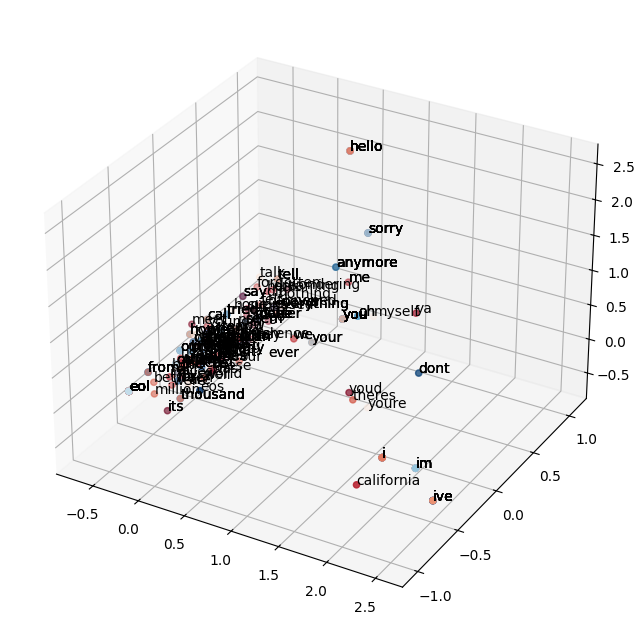

In [ ]:
# Extract the 10th lyric from the DataFrame and split it into individual words
keys = train_df['lyrics'][10].split(' ')
print(keys)

# Create a list of vectors for the words that are in the word2vec model
vectors = [word2vec[w] for w in keys if w in word2vec]

# Filter out words that are not in the word2vec model
keys = [w for w in keys if w in word2vec]

# Perform PCA to reduce the dimensions of the word vectors to 3
pca = PCA(n_components=3)
pcas = pca.fit_transform(vectors)

# Create a 3D scatter plot of the PCA-transformed word vectors
plt.figure(figsize=(25, 8))
ax = plt.axes(projection='3d')
ax.scatter(xs=pcas[:, 0], ys=pcas[:, 1], zs=pcas[:, 2], cmap='RdBu', c=range(pcas.shape[0]))

# Annotate each point with the corresponding word
for i, w in enumerate(keys):
    ax.text(pcas[i, 0], pcas[i, 1], pcas[i, 2], w)

plt.show()


In [ ]:
train_test_corpus = all_tokens + test_tokens

In [ ]:
# Initialize an empty dictionary to map indices to words
idx_to_word = {}

# Initialize a counter to serve as the index
i = 0

# Iterate over each token in the corpus
for token in train_test_corpus:
    # Map the current index to the token
    idx_to_word[i] = token
    # Increment the index
    i += 1

# Add a special token for padding at the next index
idx_to_word[i] = '<PAD>'


In [ ]:
# Initialize a counter to serve as the index
i = 0

# Initialize an empty dictionary to map words to indices
word_to_idx = {}

# Iterate over each token in the corpus
for token in train_test_corpus:
    # Map the token to the current index
    word_to_idx[token] = i
    # Increment the index
    i += 1

# Add a special token for padding at the next index
word_to_idx['<PAD>'] = i


## Dataest - Lyrics Only

Prmary data st, contain only lyrics without any additional information on midi files.

In [ ]:
def convert_indices_to_words(tensor_of_indices, word_to_idx):
    """
      Function to convert a tensor of indices to a string of corresponding words.

      Parameters:
      tensor_of_indices (Tensor): A tensor containing indices.
      word_to_idx (dict): A dictionary mapping indices to words.

      Returns:
      str: A string of words corresponding to the indices in the tensor.
    """
    list_of_words = []
    for i in range(tensor_of_indices.shape[0]):
        word_idx = tensor_of_indices[i].item()
        list_of_words.append(word_to_idx[int(word_idx)])
    return ' '.join(list_of_words)

### BLEU Score

In [ ]:
smoothie = SmoothingFunction().method4

def calculate_bleu(lyrics, output, smoothie = smoothie):
    """
      Function to calculate the BLEU score between the reference lyrics and the generated output.

      Parameters:
      lyrics (str): The reference lyrics.
      output (str): The generated output to be compared.
      smoothie (function, optional): The smoothing function to use for BLEU score calculation. Defaults to SmoothingFunction().method4.

      Returns:
      float: The BLEU score between the reference lyrics and the generated output.
    """
    # Tokenize reference and candidate sentences
    lyrics_words = lyrics.split()
    output_words = output.split()

    # Compute BLEU score with smoothing function
    bleu_score = sentence_bleu(lyrics_words, output_words, smoothing_function=smoothie)

    return bleu_score

## Midi Analsis - Model 1

### Train Set

In [ ]:
failed_files = []
def analyze_midi(path):
    """
      Function to analyze a MIDI file and extract its length, number of instruments, and tempo.

      Parameters:
      path (str): The relative path to the MIDI file.

      Returns:
      tuple: A tuple containing the file path, song length, number of instruments, and tempo. If the file fails to process, returns (path, 0.0, 0, 0.0).
    """
    full_path = directory + '/' + path
    try:
        pm = pretty_midi.PrettyMIDI(full_path)
        song_len = pm.get_end_time()
        num_instrument = len(pm.instruments)
        tempo = pm.estimate_tempo()
        return path, song_len, num_instrument, tempo
    except:
        failed_files.append(path)
        return path, 0.0, 0, 0.0


In [ ]:
results_df = train_df.apply(lambda x: analyze_midi(x[3]), axis=1, result_type='expand')
results_df.columns = ['path', 'song_length', 'num_instruments', 'estimated_tempo']

In [ ]:
train_df = train_df.merge(results_df, on='path')

In [ ]:
# now we will drop the files that failed while reading
failed_files

['Beastie_Boys_-_Girls.mid',
 'Billy_Joel_-_Pressure.mid',
 'Dan_Fogelberg_-_Leader_of_the_Band.mid',
 'Brian_McKnight_-_On_The_Down_Low.mid',
 'Aaron_Neville_-_Tell_It_Like_It_Is.mid',
 'David_Bowie_-_Lazarus.mid',
 "Billy_Joel_-_Movin'_Out.mid"]

In [ ]:
train_df = train_df.loc[~train_df['path'].isin(failed_files)].reset_index().drop('index', axis=1)

### Test Set

In [ ]:
results_df_test = test_df.apply(lambda x: analyze_midi(x[3]), axis=1, result_type='expand')
results_df_test.columns = ['path', 'song_length', 'num_instruments', 'estimated_tempo']

/tmp/ipykernel_1290211/2875472002.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_df_test = test_df.apply(lambda x: analyze_midi(x[3]), axis=1, result_type='expand')


In [ ]:
test_df = test_df.merge(results_df_test, on='path')

### Feature Creation

### Dataset

In [ ]:
def words_to_embed(lyrics, word2vec):
    """
    Function to convert words from lyrics into their corresponding embeddings using a word2vec model.
    Also tracks the positions of 'eol' tokens and collects new tokens.

    Parameters:
    lyrics (str): The lyrics to be processed.
    word2vec (dict): A dictionary mapping words to their embeddings.

    Returns:
    tuple: A tuple containing:
        - embed_list (list): A list of embeddings for the words found in word2vec.
        - eol_list (list): A list of indices where 'eol' tokens were found.
        - new_tokens (list): A list of tokens that were found in word2vec.
    """
    splited = lyrics.split()
    embed_list = []
    eol_list = []
    new_tokens = []
    i = 0
    for token in splited:
        if token in word2vec and token != "eol":
            embed_list.append(word2vec[token])
            new_tokens.append(token)
        elif token == 'eol':
            eol_list.append(i)
        i += 1
    return embed_list, eol_list,new_tokens

In [ ]:
def lyrics_to_indices(lyrics, word2idx):
    """
    Function to convert lyrics into a list of indices using a word-to-index mapping.

    Parameters:
    lyrics (str): The lyrics to be converted.
    word2idx (dict): A dictionary mapping words to their corresponding indices.

    Returns:
    list: A list of indices corresponding to the words in the lyrics.
    """
    indices = []
    for token in lyrics:
        if token != 'eol':
            indices.append(word2idx[token])
    return indices

In [ ]:
def indices_to_lyrics(indices, idx_to_word):
    """
    Function to convert a list of indices back into lyrics using an index-to-word mapping.

    Parameters:
    indices (list): A list of indices to be converted.
    idx_to_word (dict): A dictionary mapping indices to their corresponding words.

    Returns:
    list: A list of words corresponding to the indices.
    """
    lyrics = []
    for idx in indices:
        lyrics.append(idx_to_word[idx])
    return lyrics

In [ ]:
class SongsDatasetMidi(Dataset):
    def __init__(self, songs_df, word2vec, word2idx, dir):
        """
        Initializes the dataset with the provided DataFrame, word2vec model, word2idx dictionary, and directory.

        Parameters:
        songs_df (DataFrame): DataFrame containing song data.
        word2vec (dict): Dictionary mapping words to their embeddings.
        word2idx (dict): Dictionary mapping words to their indices.
        dir (str): Directory containing the MIDI files.
        """
        self.songs_df = songs_df
        self.word2vec = word2vec
        self.word2idx = word2idx
        self.dir = dir

    def __len__(self):
        """
        Returns the total number of songs in the dataset.

        Returns:
        int: Number of songs in the dataset.
        """
        return len(self.songs_df)

    def __getitem__(self, idx):
        """
        Retrieves the data for a single song at the given index.

        Parameters:
        idx (int): Index of the song to retrieve.

        Returns:
        tuple: A tuple containing input features, target indices, the first token, input lyrics, song name, and list of 'eol' positions.
        """
        input_lyrics = self.songs_df.iloc[idx, 2]
        song_name = self.songs_df.iloc[idx, 1]
        original_lyrics = input_lyrics.split()
        song_path = self.songs_df.iloc[idx, 3]
        embed_lyrics, eol_list, tokens = words_to_embed(input_lyrics, self.word2vec)
        embed_lyrics = torch.tensor(embed_lyrics, dtype=torch.float32)
        total_words = len(embed_lyrics)
        input_features = self.concat_midi_features(embed_lyrics, total_words, song_path)[:-1]
        target = torch.tensor(lyrics_to_indices(tokens, self.word2idx), dtype=torch.long)
        first_token = target[0]
        return input_features, target[1:], first_token, input_lyrics, song_name, eol_list

    def concat_midi_features(self, embed_lyrics, total_words, song_path):
        """
        Concatenates MIDI features with lyrics embeddings.

        Parameters:
        embed_lyrics (Tensor): Tensor containing lyrics embeddings.
        total_words (int): Total number of words in the lyrics.
        song_path (str): Path to the MIDI file.

        Returns:
        Tensor: A tensor containing the concatenated features.
        """
        full_path = self.dir + "/" + song_path
        pm = pretty_midi.PrettyMIDI(full_path)
        song_in_sec = pm.get_end_time()
        time_per_word = song_in_sec / total_words
        piano_matrix = pm.get_piano_roll(times=np.arange(0, song_in_sec, time_per_word)).transpose()
        max_piano_val = np.max(piano_matrix) if np.max(piano_matrix) > 0 else 1  # Avoid division by zero
        piano_matrix = piano_matrix / max_piano_val
        chroma_matrix = pm.get_chroma(times=np.arange(0, song_in_sec, time_per_word)).transpose()
        max_chroma = np.max(chroma_matrix) if np.max(chroma_matrix) > 0 else 1  # Avoid division by zero
        chroma_matrix = chroma_matrix / max_chroma

        final_embed = []
        for i in range(int(total_words)):
            chroma_for_token = torch.tensor(chroma_matrix[i], dtype=torch.float32)
            piano_for_token = torch.tensor(piano_matrix[i], dtype=torch.float32)
            combined_features = torch.cat((embed_lyrics[i], piano_for_token, chroma_for_token))
            final_embed.append(combined_features)
        return torch.stack(final_embed)

In [ ]:
train_df = train_df.sort_values(by = ['total words'])

In [ ]:
full_dataset = SongsDatasetMidi(train_df, word2vec, word_to_idx, directory)
test_dataset = SongsDatasetMidi(test_df, word2vec, word_to_idx, directory)

In [ ]:
input_features, target, first_token, input_lyrics, song_name, eol_list = full_dataset[0]

/tmp/ipykernel_1290211/898772003.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  embed_lyrics = torch.tensor(embed_lyrics, dtype=torch.float32)


In [ ]:
target.shape

torch.Size([2])

In [ ]:
# Create index list
x = list(train_df.index)

# Select features (lyrics) and target (song cat)
y = train_df['lyrics'].values
sratify = train_df['song cat'].values

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=sratify, random_state=42)


In [ ]:
train_dataset = Subset(full_dataset, X_train)
val_dataset = Subset(full_dataset, X_test)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size, num_layers=1, drop=0.4, batch_first=True, batch_norm = False):
        """
        Initializes the LSTM model.

        Parameters:
        input_size (int): The number of input features.
        hidden_size (int): The number of features in the hidden state.
        vocab_size (int): The size of the vocabulary (number of classes for the output).
        num_layers (int, optional): Number of recurrent layers. Default is 1.
        drop (float, optional): Dropout probability. Default is 0.4.
        batch_first (bool, optional): If True, the input and output tensors are provided as (batch, seq, feature). Default is True.
        batch_norm (bool, optional): If True, batch normalization is applied. Default is False.
        """
        super(LSTM, self).__init__()
        # LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)
        # Batch normalization
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        # Linear layer
        self.linear1 = nn.Linear(hidden_size, vocab_size)
        # Softmax Layer
        self.softmax = nn.Softmax(dim=2)
        # Dropout
        self.dropout = nn.Dropout(drop)
        self.batch_norm = batch_norm

    def forward(self, input, hidden=None):
        """
        Defines the forward pass of the model.

        Parameters:
        input (Tensor): The input tensor.
        hidden (tuple, optional): The hidden state and cell state.

        Returns:
        tuple: A tuple containing the output tensor and the hidden state.
        """
        output, hidden = self.lstm(input, hidden)
        output = self.dropout(output)
        output = self.linear1(output)
        return output, hidden


In [ ]:
def test(model, loader, idx_to_word, run, criterion, name, last_epoch = False, val_dataloader = None):
    """
    Function to evaluate the model on a given dataset loader.

    Parameters:
    model (nn.Module): The model to be tested.
    loader (DataLoader): DataLoader for the dataset to be tested.
    idx_to_word (dict): Dictionary mapping indices to words.
    run (object): Object to log results (e.g., a logger or experiment tracking tool).
    criterion (loss function): Loss function to calculate the loss.
    name (str): Name of the phase (e.g., 'test' or 'validation').
    last_epoch (bool, optional): Flag indicating if this is the last epoch. Default is False.
    val_dataloader (DataLoader, optional): DataLoader for validation data. Default is None.

    Returns:
    None
    """
    model.to(device)
    softmax = nn.Softmax(dim=2)
    model.eval()
    loader_tqdm = tqdm(loader, desc="Training", leave=False)
    total_loss = 0
    total_bleu = 0
    names, original_lyrics, predicted_lyrics_complete, scores = [], [], [], []
    for i, (input, target, first_token, lyrics, song_name, eol_list) in enumerate(loader_tqdm, 0):
        input, target = input.to(device), target.to(device)
        hidden = None
        logits, hidden = model(input, hidden)
        logits_flat = logits.view(-1, logits.size(-1))
        target_flat = target.view(-1)
        loss = criterion(logits_flat, target_flat)

        eol_list_int = [t.item() for t in eol_list]
        probs = softmax(logits)

        # Post-processing for BLEU and other metrics
        probs = probs.cpu().detach().numpy()
        b_score = 0
        for sample_idx in range(input.shape[0]):
            predicted_lyrics = []
            first_token = first_token[sample_idx]
            sample_probs = probs[sample_idx]
            samples = [np.random.choice(list(idx_to_word.keys()), p=p) for p in sample_probs]
            new_sample = []
            eol_count = 0
            for i in range(len(samples)):
                eol_idx = word_to_idx['eol']
                if i + 1 + eol_count in eol_list_int:
                    new_sample.extend([eol_idx, int(samples[i]) ])
                    eol_count += 1
                else:
                    new_sample.append(samples[i])
            names.append(song_name[sample_idx])
            predicted_lyrics.append(first_token.item())
            predicted_lyrics.extend(new_sample)
            predicted_list = indices_to_lyrics(predicted_lyrics, idx_to_word)
            predicted_lyrics_str = ' '.join(predicted_list)
            original_lyrics.append(lyrics[0])
            predicted_lyrics_complete.append(predicted_lyrics_str)
            b_score += calculate_bleu(lyrics[0], predicted_lyrics_str)
            scores.append(b_score)

        run[f"{name}/loss"].append(loss.item())
        run[f"{name}/bleu"].append(b_score)

        loader_tqdm.set_postfix(loss=loss.item(), bleu=b_score)

        total_loss += loss.item()
        total_bleu += b_score


    print(f"Total {name} loss: {total_loss / len(loader)}, Total bleu score: {total_bleu / len(loader)}")
    if name == 'test' or last_epoch:
    #log reports
        cv = pd.DataFrame({"song": names, "original lyrics": original_lyrics, "predicted lyrics": predicted_lyrics_complete, 'score': scores})
        run[f"{name}/prediction_report"].upload(File.as_html(cv))

    loader_tqdm.close()



In [ ]:
def train(model, train_loader, epochs, idx_to_word, optimizer, run, criterion, val_dataloader, word_to_idx):
    """
    Function to train the model.

    Parameters:
    model (nn.Module): The model to be trained.
    train_loader (DataLoader): DataLoader for the training dataset.
    epochs (int): Number of epochs to train the model.
    idx_to_word (dict): Dictionary mapping indices to words.
    optimizer (Optimizer): Optimizer for training the model.
    run (object): Object to log results (e.g., a logger or experiment tracking tool).
    criterion (loss function): Loss function to calculate the loss.
    val_dataloader (DataLoader): DataLoader for the validation dataset.
    word_to_idx (dict): Dictionary mapping words to their indices.

    Returns:
    nn.Module: The trained model.
    """
    model.to(device)
    softmax = nn.Softmax(dim=2)
    for epoch in range(epochs):
        model.train()
        loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
        total_loss = 0
        total_bleu = 0
        prev_loss = 1000000
        not_improved = 0
        names, original_lyrics, predicted_lyrics_complete, scores = [], [], [], []
        for i, (input, target, first_token, lyrics, song_name, eol_list) in enumerate(loader_tqdm, 0):
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            hidden = None
            logits, hidden = model(input, hidden)
            logits_flat = logits.view(-1, logits.size(-1))
            target_flat = target.view(-1)
            target_one_hot = F.one_hot(target,len(idx_to_word))
            loss = criterion(logits_flat, target_flat)
            loss.backward()
            optimizer.step()
            eol_list_int = [ t for t in eol_list[0]]
            probs = softmax(logits)

            # Post-processing for BLEU and other metrics
            probs = probs.cpu().detach().numpy()
            b_score = 0
            for sample_idx in range(input.shape[0]):
                predicted_lyrics = []
                first_token = first_token[sample_idx]
                sample_probs = probs[sample_idx]
                samples = [np.random.choice(list(idx_to_word.keys()), p=p) for p in sample_probs]
                new_sample = []
                eol_count = 0
                for i in range(len(samples)):
                    eol_idx = word_to_idx['eol']
                    if i + 1 + eol_count in eol_list_int:
                        new_sample.extend([eol_idx, int(samples[i]) ])
                        eol_count += 1
                    else:
                        new_sample.append(samples[i])
                names.append(song_name[sample_idx])
                predicted_lyrics.append(first_token.item())
                predicted_lyrics.extend(new_sample)
                predicted_list = indices_to_lyrics(predicted_lyrics, idx_to_word)
                predicted_lyrics_str = ' '.join(predicted_list)
                original_lyrics.append(lyrics[0])
                predicted_lyrics_complete.append(predicted_lyrics_str)
                b_score += calculate_bleu(lyrics[0], predicted_lyrics_str)
                scores.append(b_score)
            run["train/loss"].append(loss.item())
            run["train/bleu"].append(b_score)

            loader_tqdm.set_postfix(epoch=epoch, loss=loss.item(), bleu=b_score)

            total_loss += loss.item()
            total_bleu += b_score

            if (loss.item() > prev_loss):
                not_improved += 1
            else:
                not_improved = 0

            if not_improved == 5:
                run["final_epoch"].append(epoch)
                break


        # Validation at the end of each epoch
        test(model, val_dataloader, idx_to_word, run, criterion, name="val", last_epoch=epoch == epochs - 1)

        # Log and save results after the last epoch
        print(len(names), len(original_lyrics), len(predicted_lyrics_complete), len(scores))


        # if epoch == epochs - 1:
        cv = pd.DataFrame({"song": names, "original lyrics": original_lyrics, "predicted lyrics": predicted_lyrics_complete, 'score': scores})
        run[f"train/prediction_report_{epoch}"].upload(File.as_html(cv))

    return model


In [ ]:
input_size = 440
hidden_size = [8,64]
layers = [1,2]
vocab_size = len(idx_to_word)
criterion = nn.CrossEntropyLoss()
epochs = 20
learning_rate = [0.001, 0.01]
drop_out = [0.4, 0]
size = 1
norm = False
train_dataloader = DataLoader(train_dataset, batch_size=size, num_workers=6, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=size, num_workers=6, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=size, num_workers=6, shuffle=False)
for hidden in hidden_size:
    for layer in layers:
    for lr in learning_rate:
        for drop in drop_out:

            run = neptune.init_run(
            name = f"Midi1_batch size_{size}_lr_{lr}_dropout{drop}_bn_{norm}_hs{hidden_size}_l{layers}",
            project="sitri/song-generator",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwOGNjNWZlMS0yYzcwLTQ5MWUtYmQ2Zi03MTJiZGQwMjA0ZTIifQ==",
            )  # your credentials

            params = {"batch size": size, "learning_rate": lr, "optimizer": "Adam", "dropout": drop, "batch norm":norm, "epochs": epochs, "note" : "try"}
            print(params)
            run["parameters"] = params

            model = LSTM(input_size, hidden_size, vocab_size, layers, drop=drop, batch_norm=norm)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            model = train(model, train_dataloader, epochs, idx_to_word, optimizer, run, criterion,val_dataloader, word_to_idx)
            test(model, test_dataloader, idx_to_word, run, criterion, name="test")

            # Specify the path to save the checkpoint
            checkpoint_path = f'{midi_dir}/Model1_bs_{size}_lr_{lr}_dropout{drop}bn_{norm}_epochs_{epochs}_hs{hidden_size}_l{layers}'

            # Create a dictionary containing the model's state_dict and other information
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }

            # Save the checkpoint
            torch.save(checkpoint, checkpoint_path)

            run.stop()


## Midi Analsis - Model 2

In [ ]:
class SongsDatasetMidi2(Dataset):
    def __init__(self, songs_df, word2vec, word2idx, dir):
        """
          Initializes the dataset with the provided DataFrame, word2vec model, word2idx dictionary, and directory.

          Parameters:
          songs_df (DataFrame): DataFrame containing song data.
          word2vec (dict): Dictionary mapping words to their embeddings.
          word2idx (dict): Dictionary mapping words to their indices.
          dir (str): Directory containing the MIDI files.
        """
        self.songs_df = songs_df
        self.word2vec = word2vec
        self.word2idx = word2idx
        self.dir = dir

    def __len__(self):
        """
          Returns the total number of songs in the dataset.

          Returns:
          int: Number of songs in the dataset.
        """
        return len(self.songs_df)

    def __getitem__(self, idx):
        """
          Retrieves the data for a single song at the given index.

          Parameters:
          idx (int): Index of the song to retrieve.

          Returns:
          tuple: A tuple containing input features, target indices, the first token, input lyrics, song name, and list of 'eol' positions.
        """
        input_lyrics = self.songs_df.iloc[idx, 2]
        song_name = self.songs_df.iloc[idx, 1]
        original_lyrics = input_lyrics.split()
        song_path = self.songs_df.iloc[idx, 3]
        song_length = self.songs_df.iloc[idx, 9]
        num_instruments = self.songs_df.iloc[idx, 10]
        estimated_tempo = self.songs_df.iloc[idx, 11]
        embed_lyrics, eol_list, tokens = words_to_embed(input_lyrics, self.word2vec)
        embed_lyrics = torch.tensor(embed_lyrics, dtype=torch.float32)
        input_features = self.get_midi_features(embed_lyrics, song_path, song_length, num_instruments, estimated_tempo)[:-1]
        target = torch.tensor(lyrics_to_indices(tokens, self.word2idx), dtype=torch.long)
        first_token = target[0]
        return input_features, target[1:], first_token, input_lyrics, song_name, eol_list

    def get_midi_features(self, embed_lyrics, song_path, song_length, num_instruments, estimated_tempo):
        """
          Concatenates MIDI features with lyrics embeddings.

          Parameters:
          embed_lyrics (Tensor): Tensor containing lyrics embeddings.
          song_path (str): Path to the MIDI file.
          song_length (float): Length of the song in seconds.
          num_instruments (int): Number of instruments in the song.
          estimated_tempo (float): Estimated tempo of the song.

          Returns:
          Tensor: A tensor containing the concatenated features.
        """
        full_path = os.path.join(self.dir, song_path)
        pm = pretty_midi.PrettyMIDI(full_path)

        basics = np.array([song_length, num_instruments, estimated_tempo])
        notes_distribution = pm.get_pitch_class_histogram().flatten()
        count_tempo_changes = np.array([len(pm.get_tempo_changes())])

        velocities = []
        for inst in pm.instruments:
            velocities.extend([note.velocity for note in inst.notes])
        velocity_average = np.array([np.mean(velocities)])
        velocities_std = np.array([np.std(velocities)])
        beat_changes = np.array([len(pm.get_beats())])

        combined_feature = np.concatenate([
            basics, notes_distribution, count_tempo_changes, velocity_average,
            velocities_std, beat_changes
        ])

        # Repeat combined_feature to match the number of time steps in embed_lyrics
        combined_feature = np.tile(combined_feature, (embed_lyrics.size(0), 1))

        # Concatenate along the last dimension
        combined_feature = np.concatenate([combined_feature, embed_lyrics.numpy()], axis=1)

        return torch.tensor(combined_feature, dtype=torch.float32)



In [ ]:
full_dataset = SongsDatasetMidi2(train_df, word2vec, word_to_idx, directory)
test_dataset = SongsDatasetMidi2(test_df, word2vec, word_to_idx, directory)

In [ ]:
# Create index list
x = list(train_df.index)

# Select features (lyrics) and target (song cat)
y = train_df['lyrics'].values
sratify = train_df['song cat'].values

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=sratify, random_state=42)


In [ ]:
train_dataset = Subset(full_dataset, X_train)
val_dataset = Subset(full_dataset, X_test)

In [ ]:
input_size = 319
hidden_size = [8,64]
layers = [1,2]
vocab_size = len(idx_to_word)
criterion = nn.CrossEntropyLoss()
epochs = 20
learning_rate = [0.001, 0.01]
drop_out = [0, 0.4]

size = 1
norm = False

train_dataloader = DataLoader(train_dataset, batch_size=size, num_workers=6, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=size, num_workers=6, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=size, num_workers=6, shuffle=False)
for hidden in hidden_size:
    for layer in layers:
        for lr in learning_rate:
            for drop in drop_out:
                run = neptune.init_run(
                name = f"NEW_Midi2_batch size_{size}_lr_{lr}_dropout{drop}_bn_{norm}_hs{hidden_size}_l{layers}",
                project="sitri/song-generator",
                api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwOGNjNWZlMS0yYzcwLTQ5MWUtYmQ2Zi03MTJiZGQwMjA0ZTIifQ==",
                )  # your credentials

                params = {"batch size": size, "learning_rate": lr, "optimizer": "Adam", "dropout": drop, "batch norm":norm, "epochs": epochs, "note" : "try"}
                print(params)
                run["parameters"] = params

                model = LSTM(input_size, hidden_size, vocab_size, layers, drop=drop)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                model = train(model, train_dataloader, epochs, idx_to_word, optimizer, run, criterion,val_dataloader, word_to_idx)
                test(model, test_dataloader, idx_to_word, run, criterion, name="test")
                # Specify the path to save the checkpoint
                checkpoint_path = f'{midi_dir}/Model2_batch size_{size}_learning_rate_{lr}_optimizer_Adam_dropout{drop}batch_norm_{norm}_epochs_{epochs}'

                # Create a dictionary containing the model's state_dict and other information
                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }

                # Save the checkpoint
                torch.save(checkpoint, checkpoint_path)
                run.stop()


## Seed the First Word

In [ ]:
def replace_first_token(lyrics, token):
    """
      Replaces the first token of the given lyrics with the provided token.

      Parameters:
      lyrics (str): The original lyrics.
      token (str): The token to replace the first word in the lyrics.

      Returns:
      str: The modified lyrics with the first token replaced.
    """
    new_lyrics = [token]
    split_lyrics = lyrics.split()[1:]
    for token in split_lyrics:
        new_lyrics.append(token)
    return ' '.join(new_lyrics)

In [ ]:
test_df_love = test_df.copy()
test_df_love['lyrics'] = test_df_love.apply(lambda x: replace_first_token(x[2], 'dont') , axis = 1, raw = True)

In [ ]:
test_df_dataset = SongsDatasetMidi2(test_df_love, word2vec, word_to_idx, directory)

In [ ]:
input_size = 319
hidden_size = 64
layers = 1
vocab_size = len(idx_to_word)
criterion = nn.CrossEntropyLoss()

run = neptune.init_run(
name = f"Midi2_dont",
project="sitri/song-generator",
api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwOGNjNWZlMS0yYzcwLTQ5MWUtYmQ2Zi03MTJiZGQwMjA0ZTIifQ==",
)  # your credentials

params = {"batch size": 1, "learning_rate": 0.001, "optimizer": "Adam", "dropout": 0, "batch norm": False, "epochs": 20 , "note" : "love"}
print(params)
run["parameters"] = params

model = LSTM(input_size, hidden_size, vocab_size, layers, drop=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Load the checkpoint
checkpoint = torch.load(checkpoint_path)
# Load the state dict
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
test_dataloader = DataLoader(test_df_dataset)
test(model, test_dataloader, idx_to_word, run, criterion, name="test")


run.stop()

